In [ ]:
## Maybe: create plots of ratios (not of offset), consider ave ratio rather than ave offset? 

##TODO research: time series specific interpolation and difference between interpolation and mapping to new grid? 
##TODO: Visualize gap frequency and sizes
##TODO: write up NIST tech note 

In [2]:
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
 
################################################################################
#############  Functions for data loading #####################################
################################################################################

## comb data 
def open_ErYb_data(data_path, header=2):
    # keys to read out as string
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Al_ErYb", "fb_Yb_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    # # Read the CSV file
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    # Convert the strings to Decimal for the given keys
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    # reindex data
    data.index = range(len(data))
 
    return data[list(types.keys())]

## Al shift data 
def open_shiftfile_Al(datapath):
    data = pd.read_csv(datapath, header=30, delimiter="\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
## Sr shift data 
def open_shiftfile_Sr(datapath):
    data = pd.read_csv(datapath, header=22, delimiter="\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
 ## Yb shift data
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
################################################################################
#############  Functions to find optical frequencies with comb equation ########
################################################################################
 
# frequency for Al+ clock
def compute_nuAl_ErYb(data):
    data["nuAl"] = -Decimal("105e6") + Decimal("560444") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Al_ErYb"]
    data["nuAl"] = Decimal(4) * data["nuAl"]   

# frequency for Sr clock 
def compute_nuSr_ErYb(data):
    data["nuSi"] = -Decimal("105e6") + Decimal("388752") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - Decimal("100e6")
    data["nuSr"] = (Decimal("1716882") / Decimal("777577")) * (data["nuSi"] - Decimal("216e6"))


# freuency for Yb clock
def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"]
 
 
################################################################################
#############################  Load data #######################################
################################################################################
 
path = "/Users/smt3/Documents/GitHub/atomic-clock/st-interp/three_clocks/"

# load comb data
data_ErYb = open_ErYb_data(path + "20240813_Deglitched_ErYb_only1.dat")
 
# load Al shift data 
shift_data_Al = open_shiftfile_Al(path + "20240813_Al+_Freq_Shifts_ErYb.dat")

# load Sr shift data
shift_data_Sr = open_shiftfile_Sr(path + "20240813_Sr_Freq_Shifts.dat")
 
# load Yb shift data
shift_data_Yb = open_shiftfile_Yb(path + "20240813_Yb_Freq_Shifts.txt")
 
 
################################################################################
###############  get Sr and Yb optical frequencies #############################
################################################################################
 
compute_nuSr_ErYb(data_ErYb)
compute_nuYb_ErYb(data_ErYb)
compute_nuAl_ErYb(data_ErYb)
 
 
################################################################################
#########################  Data Processing #####################################
####                      Including finding common MDJ values               #####
################################################################################

#Change comb mjd type to float  
common_mjd = data_ErYb["MJD"].astype(float)
nuAl = data_ErYb["nuAl"].astype(float)
nuYb = data_ErYb["nuYb"].astype(float)
nuSr = data_ErYb["nuSr"].astype(float)

# print("Summary of the first 100 elements of the 'MJD' column")
# #summary(data_ErYb$MJD[1:100])
# print("comb: ", data_ErYb['MJD'][:100].describe())
# print("Al: ", shift_data_Al['MJD'][:100].describe())
# print("Sr: ", shift_data_Sr['MJD'][:100].describe())
# print("Yb: ", shift_data_Yb['MJD'][:100].describe()) 

# Length of the 'MJD' column
len_comb = len(common_mjd) 
len_Al = len(shift_data_Al['MJD'])                  
len_Sr = len(shift_data_Sr['MJD'])
len_Yb = len(shift_data_Yb['MJD'])

# print("Summary of the last 100 elements of the 'MJD' column")
# print("comb: ", data_ErYb['MJD'][(len_comb-100):].describe())
# print("Al: ", shift_data_Al['MJD'][(len_Al-100):].describe())
# print("Sr: ", shift_data_Al['MJD'][(len_Sr-100):].describe())
# print("Yb: ", shift_data_Al['MJD'][(len_Yb-100):].describe())

## Find intersecting indices and adjust data accordingly 
#function to extract element as close to target as possible w/out going over
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data[inx] <= target:
            inx += 1
        else:
            return inx  

#function to extract element as close to target as possible w/out going under 
def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data[len(data)-inx] >= target:
            inx += 1
        else:
            return len(data)-inx  

# Lower bound indices for each data set 
# print(shift_data_Sr["MJD"][0])
comb_lb_inx = lb_extract(target = shift_data_Sr["MJD"][0], data = common_mjd)
Al_lb_inx = lb_extract(target = shift_data_Sr["MJD"][0], data = shift_data_Al["MJD"])
Yb_lb_inx = lb_extract(target = shift_data_Sr["MJD"][0], data = shift_data_Yb["MJD"])
# print(common_mjd[1865])
# print(shift_data_Al["MJD"][39324])
# print(shift_data_Yb["MJD"][1633])

# Upper bound indices for each data set 
# print(common_mjd[len_comb-1])
Al_ub_inx = ub_extract(target = common_mjd[len_comb-1], data = shift_data_Al["MJD"])
Sr_ub_inx = ub_extract(target = common_mjd[len_comb-1], data = shift_data_Sr["MJD"])
Yb_ub_inx = ub_extract(target = common_mjd[len_comb-1], data = shift_data_Yb["MJD"])
# print(shift_data_Al["MJD"][57191])
# print(shift_data_Sr["MJD"][1975])
# print(shift_data_Yb["MJD"][21443])

#comb MJD index 
comb = pd.DataFrame()
comb["MJD"] = common_mjd[comb_lb_inx:(len_comb-1)]
## make the following part of common_mjd data frame 
comb["nuAl"] = nuAl[comb_lb_inx:(len_comb-1)]
comb["nuYb"] = nuYb[comb_lb_inx:(len_comb-1)]
comb["nuSr"] = nuSr[comb_lb_inx:(len_comb-1)]

#Al MJD index
shift_data_Al = shift_data_Al[Al_lb_inx:Al_ub_inx]
# print("Al: ", shift_data_Al["MJD"].describe())

#Sr MJD index 
shift_data_Sr = shift_data_Sr[:Sr_ub_inx]
# print("Sr: ", shift_data_Sr["MJD"].describe())

#Yb MJD index 
shift_data_Yb = shift_data_Yb[Yb_lb_inx:Yb_ub_inx]
# print("Yb: ", shift_data_Yb["MJD"].describe()


In [3]:
## View attributes of the complete data set
print(comb.columns)
#print(comb["MJD"].dtype)
#print(comb["nuAl"].dtype)
print(shift_data_Al.columns)
print(shift_data_Sr.columns)
print(shift_data_Yb.columns)

## Change comb values to high precision decimal (for zip compatability later)
comb["nuAl"] = [Decimal(i) for i in comb["nuAl"]]
comb["nuSr"] = [Decimal(i) for i in comb["nuSr"]]
comb["nuYb"] = [Decimal(i) for i in comb["nuYb"]]

Index(['MJD', 'nuAl', 'nuYb', 'nuSr'], dtype='object')
Index(['MJD', 'shift', 'IS_GOOD'], dtype='object')
Index(['MJD', 'shift', 'IS_GOOD'], dtype='object')
Index(['MJD', 'shift', 'IS_GOOD'], dtype='object')


1673


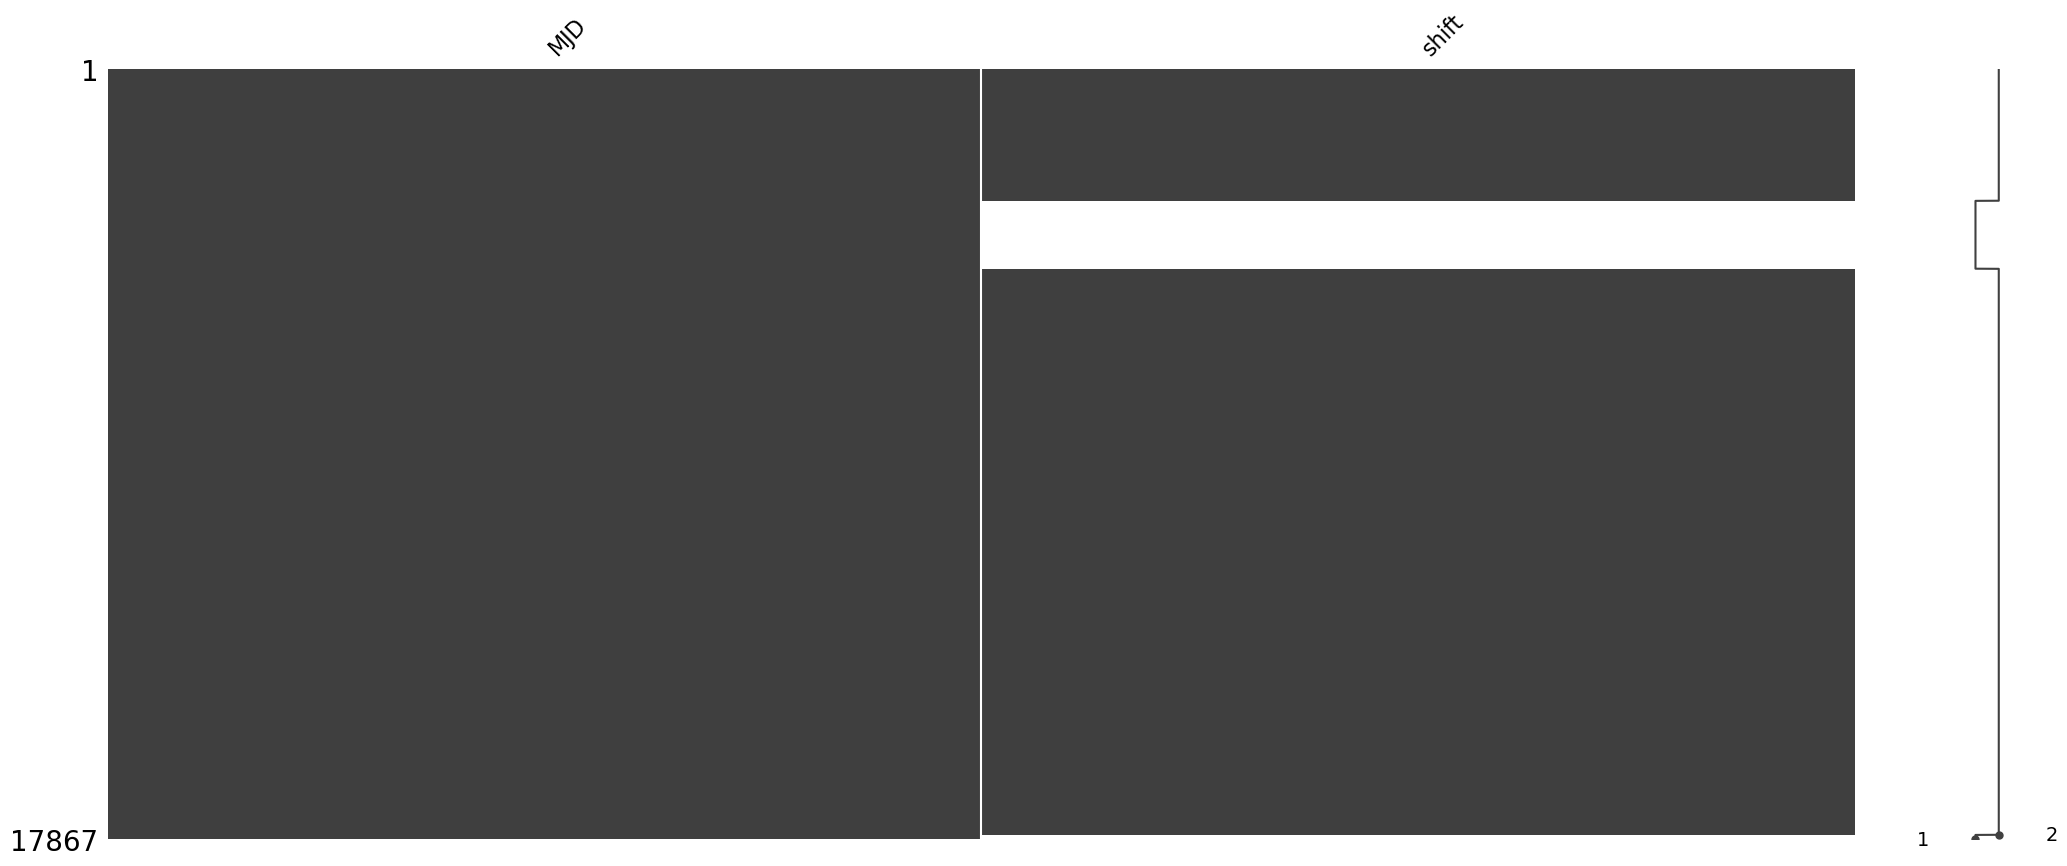

1


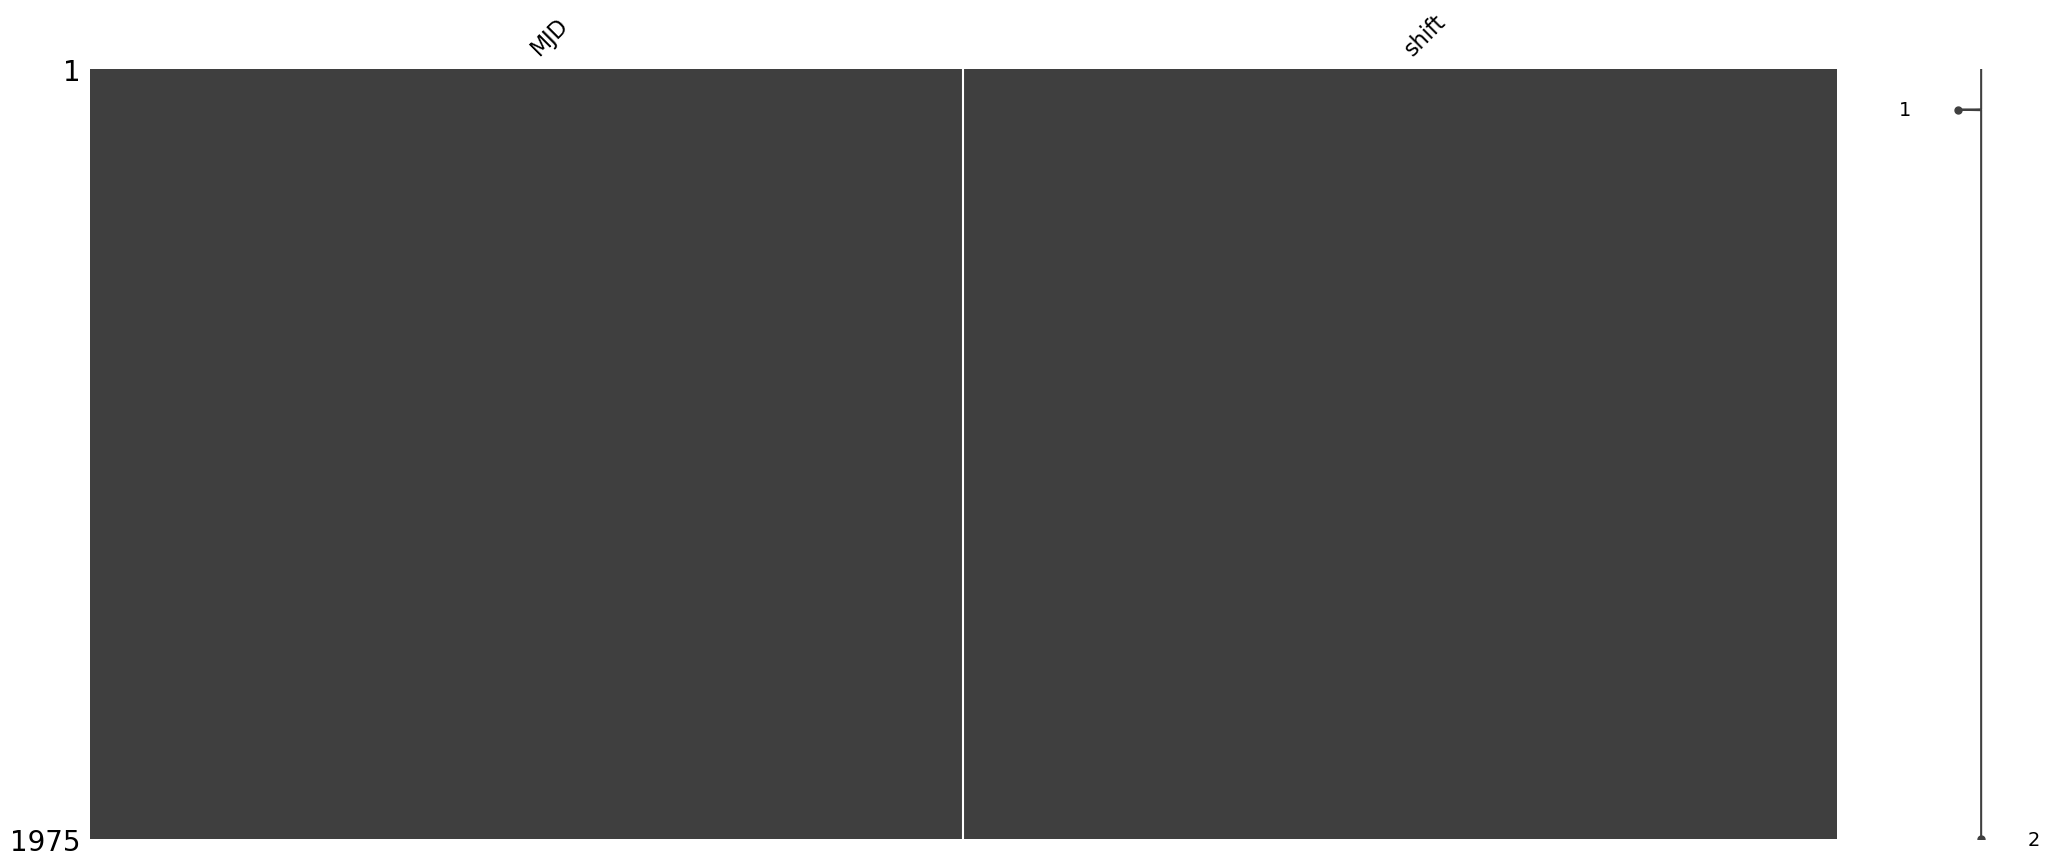

1877


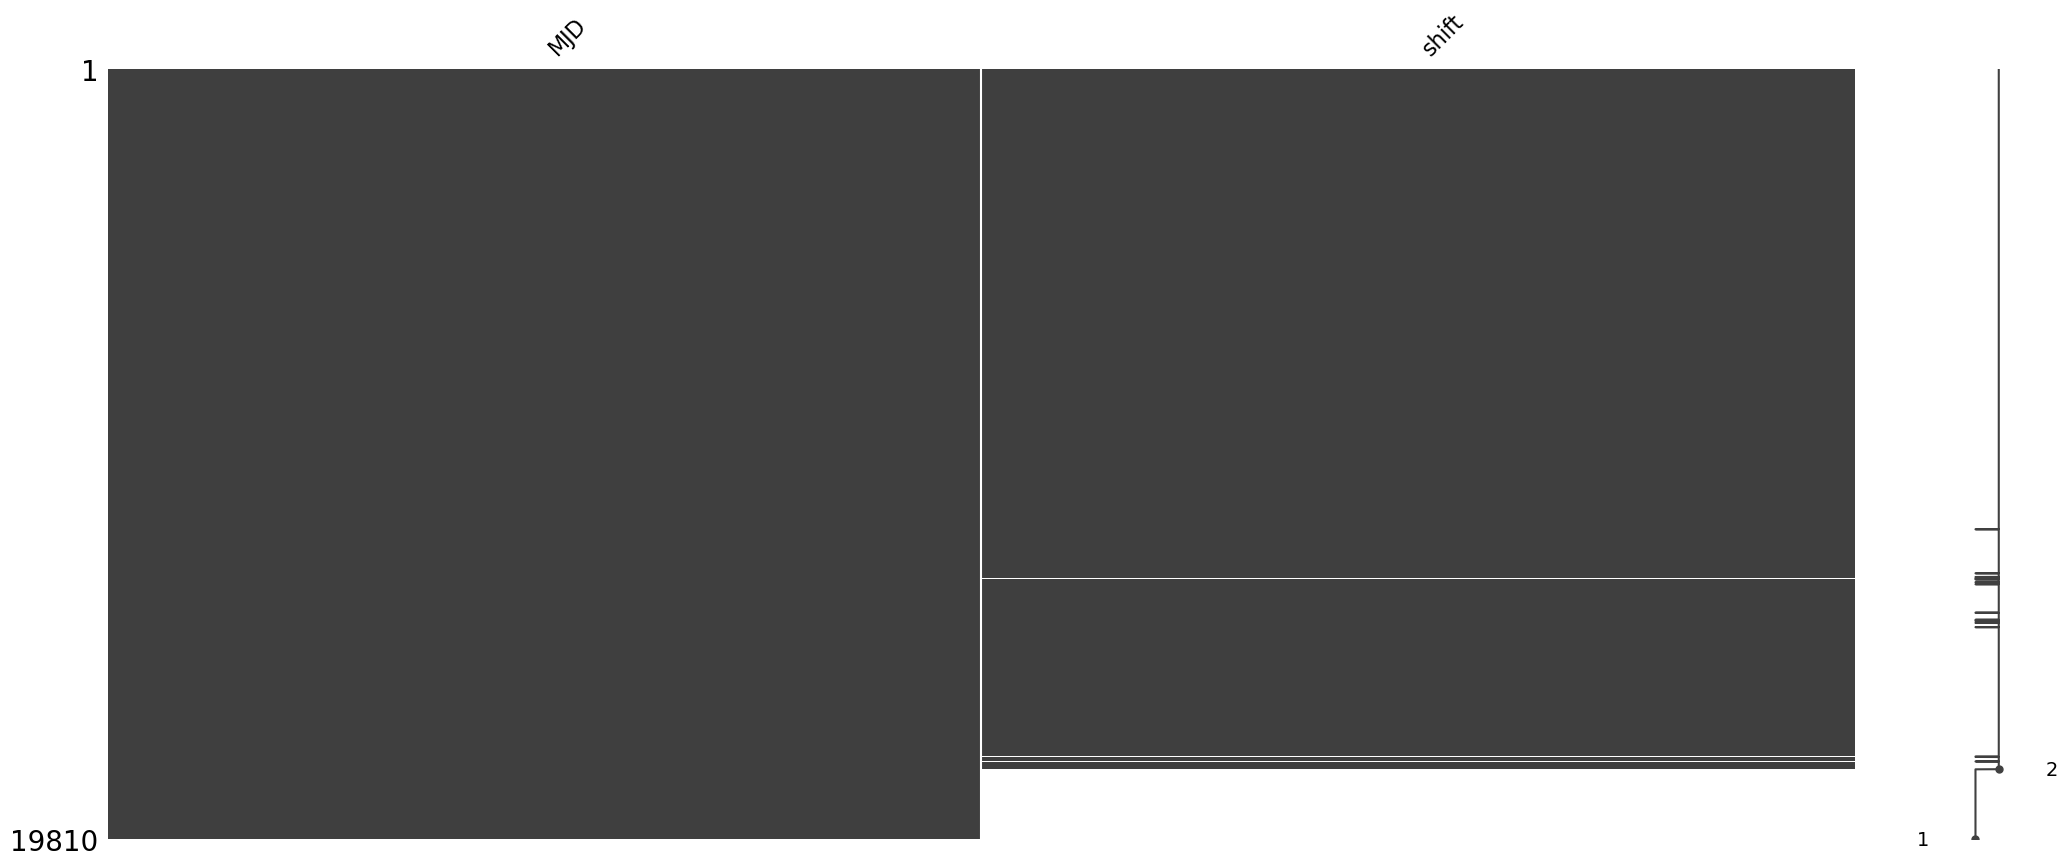

In [8]:
## Visualize gaps in data before imputing 
##Note: first install missingno package into myenv via terminal
## cd ~/anaconda3/envs/myenv
## pip install missingno 

import missingno as msno
atts = ["MJD", "shift"]

miss_inx_Al = pd.isnull(shift_data_Al["shift"])
print(miss_inx_Al.sum())
msno.matrix(shift_data_Al[atts])
plt.show()

miss_inx_Sr = pd.isnull(shift_data_Sr["shift"])
print(miss_inx_Sr.sum())
msno.matrix(shift_data_Sr[atts])
plt.show()

miss_inx_Yb = pd.isnull(shift_data_Yb["shift"])
print(miss_inx_Yb.sum())
msno.matrix(shift_data_Yb[atts])
plt.show()

In [4]:
################################################################################
#########################  Interpolation techniques  ###########################
################################################################################
# Method 1) Use numpy.interp to interpolate Al, Sr, and Yb shift values onto 
#           comb MJD values 
shiftAl1 = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_data_Al["shift"])
shiftSr1 = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_data_Sr["shift"])
shiftYb1 = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_data_Yb["shift"])

# change Method 1 data type to high-precision Decimal
shiftAl1 = [Decimal(i) for i in shiftAl1]
shiftSr1 = [Decimal(i) for i in shiftSr1]
shiftYb1 = [Decimal(i) for i in shiftYb1]

# Method 2) Use pandas.interpolate to impute the missing data from Al, Sr, and Yb;
#           then use numpy.interp to interpolate Al, Sr, and Yb shift values onto 
#           comb MJD values
# Step 1
interp_method = "linear" #time (note: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex)
shift_Al_tmp = shift_data_Al["shift"].interpolate(method=interp_method)
shift_Sr_tmp = shift_data_Sr["shift"].interpolate(method=interp_method)
shift_Yb_tmp = shift_data_Yb["shift"].interpolate(method=interp_method)
# Step 2 
shiftAl2 = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_Al_tmp)
shiftSr2 = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_Sr_tmp)
shiftYb2 = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_Yb_tmp)

# change Method 2 data type to high-precision Decimal
shiftAl2 = [Decimal(i) for i in shiftAl2]
shiftSr2 = [Decimal(i) for i in shiftSr2]
shiftYb2 = [Decimal(i) for i in shiftYb2]

# Method 3) Same as Method 2 except don't use pandas.interpolate on any
#           sequential NaNs longer than my_limit 
# Step 1
my_limit = 3
shift_Al_tmp3 = shift_data_Al["shift"].interpolate(method=interp_method, limit=my_limit)
shift_Sr_tmp3 = shift_data_Sr["shift"].interpolate(method=interp_method, limit=my_limit)
shift_Yb_tmp3 = shift_data_Yb["shift"].interpolate(method=interp_method, limit=my_limit)
# Step 2 
shiftAl3 = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_Al_tmp3)
shiftSr3 = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_Sr_tmp3)
shiftYb3 = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_Yb_tmp3)

# change Method 3 data type to high-precision Decimal
shiftAl3 = [Decimal(i) for i in shiftAl3]
shiftSr3 = [Decimal(i) for i in shiftSr3]
shiftYb3 = [Decimal(i) for i in shiftYb3]
 

In [5]:

################################################################################
#############################  Plotting  #######################################
################################################################################
 
# Ratios from 2020
YbSrRatio2020 = Decimal("1.2075070393433378482") 
AlYbRatio2020 = Decimal("2.162887127516663703")
AlSrRatio2020 = Decimal("2.611701431781463025")
 
# frequency corrections
masercorrection = Decimal("-7.36631e-12")
GR_shift_Al = Decimal("-8.114e-16")
GR_shift_Yb = Decimal("-8.109e-16")
GR_shift_Sr = Decimal("10.660e-16")
GR_shift_sea_level = Decimal("-1798.501e-16")

total_correction_Yb = Decimal("1") + GR_shift_Yb + GR_shift_sea_level + masercorrection
total_correction_Sr = Decimal("1") + GR_shift_Sr + GR_shift_sea_level + masercorrection
total_correction_Al = Decimal("1") + GR_shift_Al + GR_shift_sea_level + masercorrection



Yb/Sr ratio offset from BACON paper (Method 1) -1.0842E-16


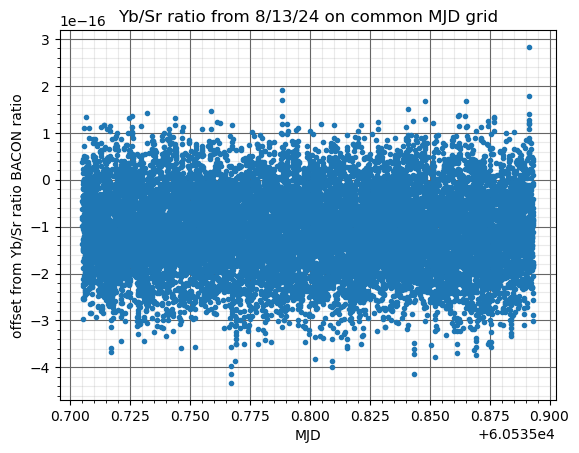

Al/Yb ratio offset from BACON paper (Method 1) -1.8751E-17


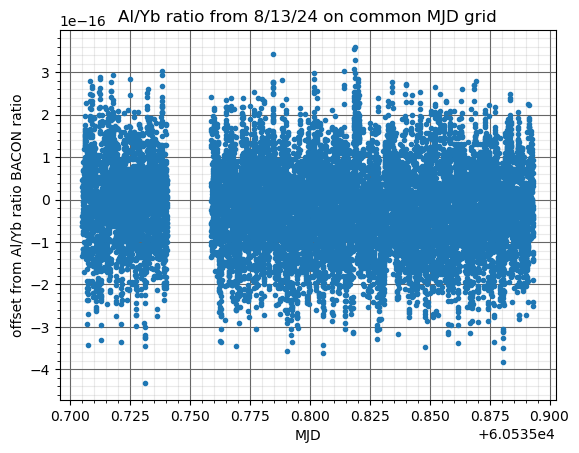

Al/Sr ratio offset from BACON paper (Method 1) -1.2708E-16


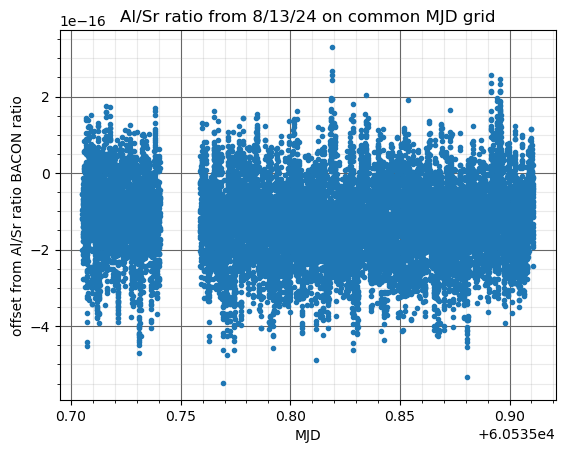

In [6]:
## Method 1)
# add comb frequencies and clock shift files
frequency_Yb_ErYb1 = [(i + j) * total_correction_Yb for i,j in zip(comb["nuYb"], shiftYb1)]
frequency_Sr_ErYb1 = [(i + j) * total_correction_Sr for i,j in zip(comb["nuSr"], shiftSr1)]
frequency_Al_ErYb1 = [(i + j) * total_correction_Al for i,j in zip(comb["nuAl"], shiftAl1)]
 

# Yb/Sr ratio offset from BACON paper
frequency_ratio_ErYb1_1 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb1, frequency_Sr_ErYb1)]
print("Yb/Sr ratio offset from BACON paper (Method 1)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_1)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1_1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Yb ratio offset 
frequency_ratio_ErYb2_1 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb1, frequency_Yb_ErYb1)]
print("Al/Yb ratio offset from BACON paper (Method 1)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_1)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2_1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Yb ratio BACON ratio")
plt.title("Al/Yb ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Sr ratio offset  
frequency_ratio_ErYb3_1 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb1, frequency_Sr_ErYb1)]
print("Al/Sr ratio offset from BACON paper (Method 1)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_1)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3_1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al/Sr ratio from 8/13/24 on common MJD grid")
plt.show()

Yb/Sr ratio offset from BACON paper (Method 2)

 -1.0867E-16


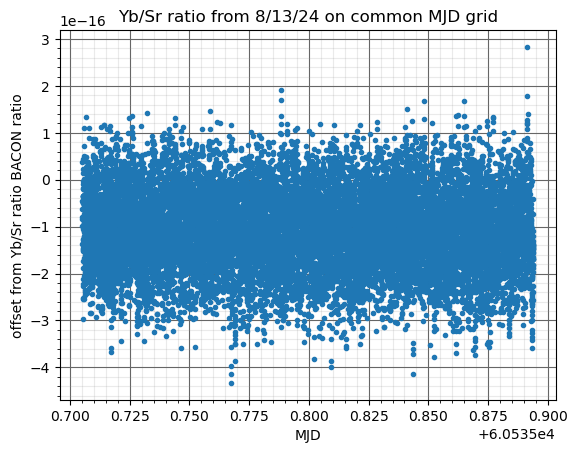

Al/Yb ratio offset from BACON paper (Method 2) -1.2848E-17


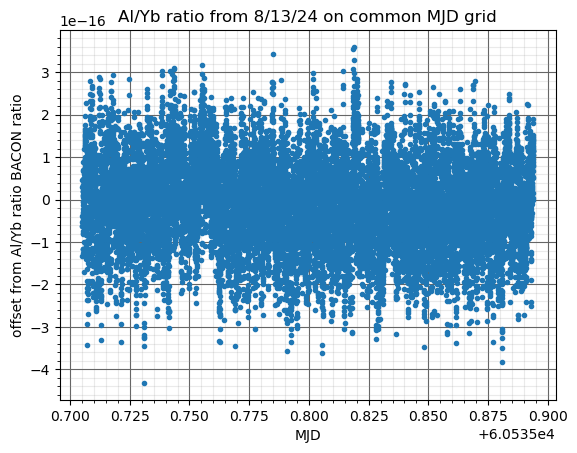

Al/Sr ratio offset from BACON paper (Method 2) -1.2141E-16


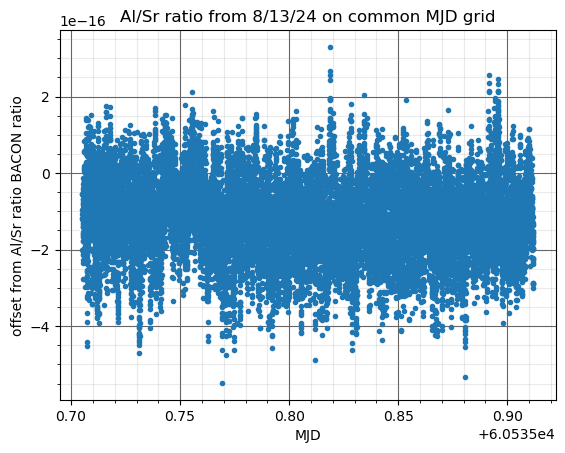

In [7]:
## Method 2)
# add comb frequencies and clock shift files
frequency_Yb_ErYb2 = [(i + j) * total_correction_Yb for i,j in zip(comb["nuYb"], shiftYb2)]
frequency_Sr_ErYb2 = [(i + j) * total_correction_Sr for i,j in zip(comb["nuSr"], shiftSr2)]
frequency_Al_ErYb2 = [(i + j) * total_correction_Al for i,j in zip(comb["nuAl"], shiftAl2)]
 

# Yb/Sr ratio offset from BACON paper
frequency_ratio_ErYb1_2 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb2, frequency_Sr_ErYb2)]
print("Yb/Sr ratio offset from BACON paper (Method 2)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_2)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1_2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Yb ratio offset 
frequency_ratio_ErYb2_2 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb2, frequency_Yb_ErYb2)]
print("Al/Yb ratio offset from BACON paper (Method 2)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_2)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2_2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Yb ratio BACON ratio")
plt.title("Al/Yb ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Sr ratio offset  
frequency_ratio_ErYb3_2 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb2, frequency_Sr_ErYb2)]
print("Al/Sr ratio offset from BACON paper (Method 2)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_2)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3_2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al/Sr ratio from 8/13/24 on common MJD grid")
plt.show()

Yb/Sr ratio offset from BACON paper (Method 3) -1.0837E-16


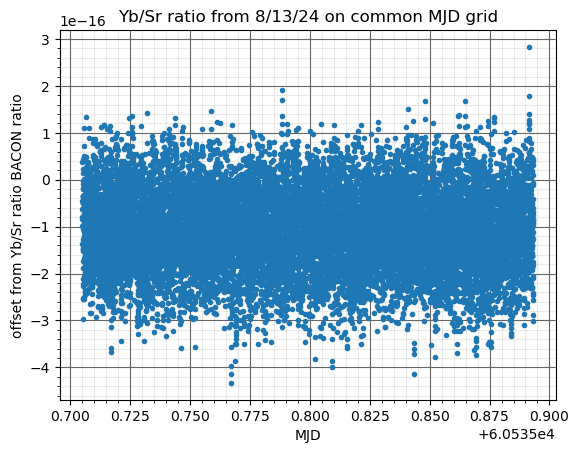

Al/Yb ratio offset from BACON paper (Method 3) -1.8844E-17


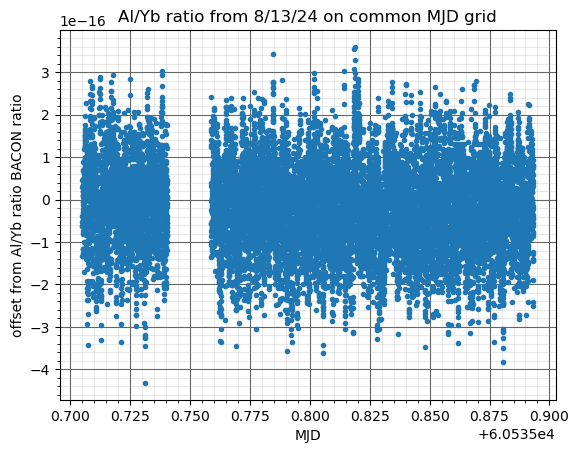

Al/Sr ratio offset from BACON paper (Method 3) -1.2701E-16


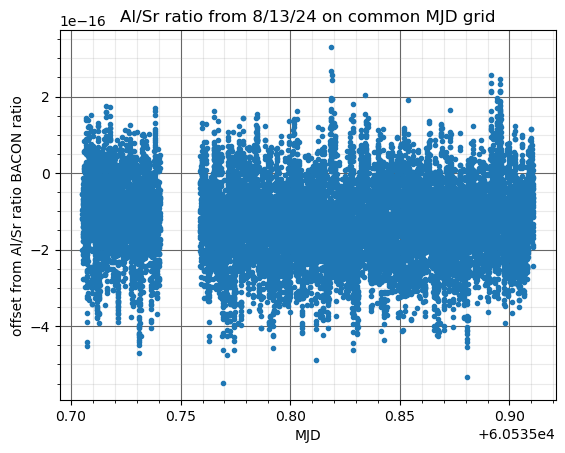

In [8]:
## Method 3)
# add comb frequencies and clock shift files
frequency_Yb_ErYb3 = [(i + j) * total_correction_Yb for i,j in zip(comb["nuYb"], shiftYb3)]
frequency_Sr_ErYb3 = [(i + j) * total_correction_Sr for i,j in zip(comb["nuSr"], shiftSr3)]
frequency_Al_ErYb3 = [(i + j) * total_correction_Al for i,j in zip(comb["nuAl"], shiftAl3)]
 

# Yb/Sr ratio offset from BACON paper
frequency_ratio_ErYb1_3 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb3, frequency_Sr_ErYb3)]
print("Yb/Sr ratio offset from BACON paper (Method 3)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_3)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1_3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Yb ratio offset 
frequency_ratio_ErYb2_3 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb3, frequency_Yb_ErYb3)]
print("Al/Yb ratio offset from BACON paper (Method 3)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_3)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2_3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Yb ratio BACON ratio")
plt.title("Al/Yb ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Sr ratio offset  
frequency_ratio_ErYb3_3 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb3, frequency_Sr_ErYb3)]
print("Al/Sr ratio offset from BACON paper (Method 3)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_3)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3_3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al/Sr ratio from 8/13/24 on common MJD grid")
plt.show()

In [9]:
print("Method 1")
print("Yb/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_1)) )
print("Al/Yb:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_1)) )
print("Al/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_1)) )

print("Method 2")
print("Yb/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_2)) )
print("Al/Yb:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_2)) )
print("Al/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_2)) )

print("Method 3")
print("Yb/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_3)) )
print("Al/Yb:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_3)) )
print("Al/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_3)) )

Method 1
Yb/Sr: -1.0842E-16
Al/Yb: -1.8751E-17
Al/Sr: -1.2708E-16
Method 2
Yb/Sr: -1.0867E-16
Al/Yb: -1.2848E-17
Al/Sr: -1.2141E-16
Method 3
Yb/Sr: -1.0837E-16
Al/Yb: -1.8844E-17
Al/Sr: -1.2701E-16
